<font size=8>Create Synthetic WOD</font>

This notebook subsamples the output of a numerical ocean model using the locations of observations from the World Ocean Database
The xESMF tool is used to subsample the model temperature and salinity fields



In [1]:
import os
import dask
import numpy as np
import pandas as pd
import dask.array as dask
import dask.bag as db
from matplotlib import pyplot as plt
import xarray 
import xesmf 

In [5]:
xarray.set_options(keep_attrs=True) ## This ensures that performing simple operations with xarray (eg converting temperature to Celsius) preserves attributes

from dask.distributed import Client
client = Client()
client

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/distributed/node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36187 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/36187/status,
Dashboard: /proxy/36187/status,Workers: 4
Total threads: 4,Total memory: 18.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44051,Workers: 4
Dashboard: /proxy/36187/status,Total threads: 4
Started: Just now,Total memory: 18.00 GiB
Comm: tcp://127.0.0.1:34547,Total threads: 1
Dashboard: /proxy/33519/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:36387,


Load the model field (here from the 0.1 degree COSIMA model suite)

In [6]:
model_data_base_path = '/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v140_iaf/'

model_subdirs = os.listdir(model_data_base_path)
model_subdirs.sort()

model_temperature_files = []

for i_subdir in model_subdirs:
    #print(i_subdir)
    if os.path.isdir(os.path.join(model_data_base_path,i_subdir)) and "output" in i_subdir:
        model_output_directory = os.path.join(model_data_base_path,i_subdir,'ocean')
        model_output_dir_contents = os.listdir(model_output_directory)
        
        model_output_dir_contents.sort()
        
        for i_file in model_output_dir_contents:
            
            if os.path.isfile(os.path.join(model_output_directory,i_file)) and i_file.startswith("ocean-3d-temp-1-daily-mean"):
                #print(i_file)
                model_temperature_files.append(os.path.join(model_output_directory,i_file))
        
        #print(i_subdir)


In [7]:
model_temperature_dataset = xarray.open_mfdataset(model_temperature_files)#.to_dask() #,concat_dim='time')

In [9]:
model_temperature_dataset

<xarray.Dataset>
Dimensions:         (xt_ocean: 3600, yt_ocean: 2700, st_ocean: 75,
                     st_edges_ocean: 76, time: 11688, nv: 2)
Coordinates:
  * xt_ocean        (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.85 79.95
  * yt_ocean        (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.94 89.98
  * st_ocean        (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * st_edges_ocean  (st_edges_ocean) float64 0.0 1.083 ... 5.61e+03 5.809e+03
  * time            (time) datetime64[ns] 1987-01-01T12:00:00 ... 2018-12-31T...
  * nv              (nv) float64 1.0 2.0
Data variables:
    temp            (time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(31, 75, 2700, 3600), meta=np.ndarray>
    average_T1      (time) datetime64[ns] dask.array<chunksize=(31,), meta=np.ndarray>
    average_T2      (time) datetime64[ns] dask.array<chunksize=(31,), meta=np.ndarray>
    average_DT      (time) timedelta64[ns] dask.array<chunksize=(31,), meta=np.ndarray>
    time_bounds     (time, nv) timedelta64[ns] dask.array<chunksize=(31, 2), meta=np.ndarray>
Attributes:
    filename:   ocean-3d-temp-1-daily-mean-ym_1987_01.nc
    title:      ACCESS-OM2-01
    grid_type:  mosaic
    grid_tile:  1
    history:    20200704T1458Z: /g/data/ik11/inputs/access-om2/bin/mppnccombi...

In [8]:
grid010 = xarray.open_dataset('/g/data/ik11/grids/ocean_grid_01.nc')
grid010 = grid010.rename({'grid_x_C': 'xu_ocean', 'grid_y_C': 'yu_ocean',
                          'grid_x_T': 'xt_ocean', 'grid_y_T': 'yt_ocean'})

In [7]:
model_temperature_dataset = model_temperature_dataset.assign_coords({'geolat_t': grid010.geolat_t, 'geolon_t': grid010.geolon_t})
model_temperature_dataset = model_temperature_dataset.rename({'xt_ocean': 'x', 'yt_ocean': 'y',
                                                              'geolon_t': 'longitude', 'geolat_t': 'latitude'})


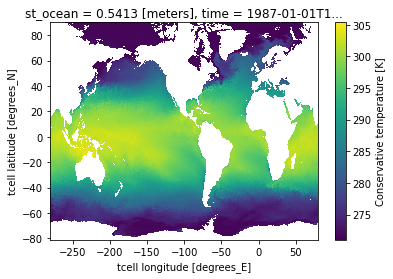

In [5]:
model_temperature_dataset['temp'][0,0,:,:].plot()

In [9]:
#lon_name = 'xt_ocean'
#model_temperature_dataset = model_temperature_dataset.assign_coords({lon_name: (model_temperature_dataset[lon_name] + 360)  % 360})
#model_temperature_dataset.sortby(model_temperature_dataset)
#ds_out = ds_out.assign_coords({'lon': ds_out.lon - 100.})
#model_temperature_dataset = model_temperature_dataset.assign_coords({lon_name: (model_temperature_dataset[lon_name] + (90+280)) % 360})
#model_temperature_dataset = model_temperature_dataset.assign_coords({lon_name: (model_temperature_dataset[lon_name] - 100)})

In [10]:
LAT_LIMIT_SOUTH = -50
LAT_LIMIT_NORTH = 0

LON_LIMIT_WEST = -280
LON_LIMIT_EAST = -180

model_longitude_grid_offset = -280



model_temperature_dataset = model_temperature_dataset.sel(xt_ocean=slice(LON_LIMIT_WEST,LON_LIMIT_EAST),
                                                          yt_ocean=slice(LAT_LIMIT_SOUTH,LAT_LIMIT_NORTH),time=slice("2018",'2019'))

In [8]:
model_temperature_level

<xarray.Dataset>
Dimensions:         (xt_ocean: 1000, yt_ocean: 579, st_edges_ocean: 76,
                     time: 365, nv: 2)
Coordinates:
  * xt_ocean        (xt_ocean) float64 -279.9 -279.8 -279.7 ... -180.1 -180.0
  * yt_ocean        (yt_ocean) float64 -49.96 -49.9 -49.83 ... -0.25 -0.15 -0.05
    st_ocean        float64 0.5413
  * st_edges_ocean  (st_edges_ocean) float64 0.0 1.083 ... 5.61e+03 5.809e+03
  * time            (time) datetime64[ns] 2018-01-01T12:00:00 ... 2018-12-31T...
  * nv              (nv) float64 1.0 2.0
Data variables:
    temp            (time, yt_ocean, xt_ocean) float32 279.1 278.9 ... 302.9
    average_T1      (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2018-12-31
    average_T2      (time) datetime64[ns] 2018-01-02 2018-01-03 ... 2019-01-01
    average_DT      (time) timedelta64[ns] 1 days 1 days ... 1 days 1 days
    time_bounds     (time, nv) timedelta64[ns] 43099 days ... 43464 days
Attributes:
    filename:   ocean-3d-temp-1-daily-mean-ym_1987_01.nc
    title:      ACCESS-OM2-01
    grid_type:  mosaic
    grid_tile:  1
    history:    20200704T1458Z: /g/data/ik11/inputs/access-om2/bin/mppnccombi...

In [12]:
model_temperature_dataset = model_temperature_dataset.chunk({'time':5,'st_ocean':1,'x':-1,'y':-1})

In [6]:
model_temperature_dataset

<xarray.Dataset>
Dimensions:         (xt_ocean: 1000, yt_ocean: 579, st_ocean: 75,
                     st_edges_ocean: 76, time: 365, nv: 2)
Coordinates:
  * xt_ocean        (xt_ocean) float64 -279.9 -279.8 -279.7 ... -180.1 -180.0
  * yt_ocean        (yt_ocean) float64 -49.96 -49.9 -49.83 ... -0.25 -0.15 -0.05
  * st_ocean        (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * st_edges_ocean  (st_edges_ocean) float64 0.0 1.083 ... 5.61e+03 5.809e+03
  * time            (time) datetime64[ns] 2018-01-01T12:00:00 ... 2018-12-31T...
  * nv              (nv) float64 1.0 2.0
Data variables:
    temp            (time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(31, 75, 579, 1000), meta=np.ndarray>
    average_T1      (time) datetime64[ns] dask.array<chunksize=(31,), meta=np.ndarray>
    average_T2      (time) datetime64[ns] dask.array<chunksize=(31,), meta=np.ndarray>
    average_DT      (time) timedelta64[ns] dask.array<chunksize=(31,), meta=np.ndarray>
    time_bounds     (time, nv) timedelta64[ns] dask.array<chunksize=(31, 2), meta=np.ndarray>
Attributes:
    filename:   ocean-3d-temp-1-daily-mean-ym_1987_01.nc
    title:      ACCESS-OM2-01
    grid_type:  mosaic
    grid_tile:  1
    history:    20200704T1458Z: /g/data/ik11/inputs/access-om2/bin/mppnccombi...

Load the World Ocean Database data


In [11]:
WOD_base_file_path ='/g/data/ul08/WOD_2018'

year = 2018
WOD_file_name_stem = 'wod_'


obs_platform_type = ['ctd','xbt','pfl','mrb','gld','drb','osd']

WOD_object = dict(zip(obs_platform_type, [None]*len(obs_platform_type)))


for i_platform_type in obs_platform_type:
    
    WOD_object[i_platform_type] = xarray.open_dataset(os.path.join(WOD_base_file_path,str(2018),
                                                                   WOD_file_name_stem + i_platform_type + '_' + str(year) + '.nc') )
    


In [12]:
platform_type = 'xbt'

WOD_lat = WOD_object[platform_type]['lat'].copy().values
WOD_lon = WOD_object[platform_type]['lon'].copy().values


In [13]:
WOD_lon[WOD_lon>90] = WOD_lon[WOD_lon>90] - (270+90) 

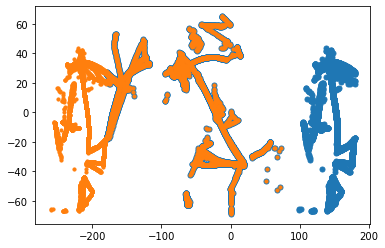

In [14]:
plt.scatter(WOD_object[platform_type]['lon'],WOD_object[platform_type]['lat'],s=25)
plt.scatter(WOD_lon,WOD_lat,s=10)


In [15]:
ds_WOD_stations = xarray.Dataset()
ds_WOD_stations['longitude'] = xarray.DataArray(data=WOD_lon, dims=('casts'))
ds_WOD_stations['latitude'] = xarray.DataArray(data=WOD_lat, dims=('casts'))
ds_WOD_stations['time'] = xarray.DataArray(data=WOD_object[platform_type]['time'].values, dims=('casts'))

ds_WOD_stations = ds_WOD_stations.where(np.logical_and(ds_WOD_stations['longitude']>-280,
                                                       ds_WOD_stations['longitude']<-180),drop=True)
ds_WOD_stations = ds_WOD_stations.where(np.logical_and(ds_WOD_stations['latitude']>-50,
                                                       ds_WOD_stations['latitude']<0),drop=True)


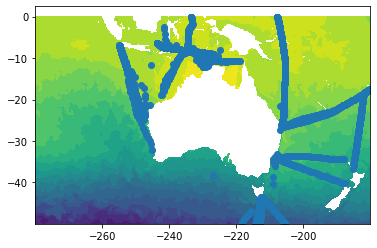

In [16]:
plt.contourf(model_temperature_dataset['temp']['xt_ocean'],model_temperature_dataset['temp']['yt_ocean'],
             model_temperature_dataset['temp'][0,0,:,:],25)
plt.scatter(ds_WOD_stations['longitude'],ds_WOD_stations['latitude'])

#plt.scatter(WOD_lon,WOD_lat,s=10)


In [23]:
WOD_object['pfl']['z'].max()

<xarray.DataArray 'z' ()>
array(5885.00146484)
Attributes:
    standard_name:        depth
    long_name:            depth_below_sea_surface
    units:                m
    positive:             down
    ancillary_variables:  z_sigfigs z_WODflag z_origflag

In [34]:
#model_temperature = model_temperature.drop({'x', 'y'}).cf.to_dataset()


#model_temperature = model_temperature.sel(time=ds_WOD_stations['time'].values,method='nearest')

#model_temperature = model_temperature.chunk({'time':5,'st_ocean':-1,'y':-1,'x':-1})

In [17]:
max_depth = 800

n_levels = model_temperature_dataset['st_ocean'].sel(st_ocean=slice(0,max_depth)).size
n_casts  = ds_WOD_stations['casts'].size
KELVIN_TO_CELSIUS = -273.15



WOD_temperature_synthetic = xarray.DataArray(np.zeros([n_casts,n_levels],dtype=np.float32),
                                             dims=['casts','depth'],
                                             coords={'casts':ds_WOD_stations['casts'],
                                                     'depth':model_temperature_dataset['st_ocean'][0:n_levels].values}).to_dataset(name='temp')
WOD_temperature_synthetic['latitude'] = ds_WOD_stations['latitude']


WOD_temperature_synthetic['longitude'] = ds_WOD_stations['longitude']
WOD_temperature_synthetic['time'] = ds_WOD_stations['time']



#model_temperature_level = model_temperature_dataset['temp'].sel(st_ocean=slice(0,max_depth)) 


for i_level in range(25,n_levels):
    model_temperature_level = model_temperature_dataset['temp'].isel(st_ocean=i_level).load() 
    model_temperature_level = model_temperature_level + KELVIN_TO_CELSIUS
    
    
    regridder = xesmf.Regridder(model_temperature_level, ds_WOD_stations, 'bilinear', locstream_out=True) #,reuse_weights=True)
    
    WOD_temperature_synthetic_level = regridder(model_temperature_level)
    WOD_temperature_synthetic_level.to_netcdf(os.path.join('/g/data4/ul08/CARS_v2/Synthetic_WOD/staging', 
                                                           'WOD_synthetic_' + platform_type + '_2018_' + 'level_' + str(i_level) +  '.nc') ) 
    
    
    WOD_temperature_synthetic['temp'][:,i_level] = WOD_temperature_synthetic_level.sel(time=ds_WOD_stations['time'],method='nearest')
    
    


/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/xarray/core/dataarray.py:856: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/xarray/core/dataarray.py:856: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/xarray/core/dataarray.py:856: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/xarray/core/dataarray.py:856: FutureWarning: elementwise comparison failed; returning scalar instead, but in the futur

In [20]:
WOD_temperature_synthetic_level

<xarray.Dataset>
Dimensions:                        (time: 365, casts: 3240)
Coordinates:
    st_ocean                       float64 ...
  * time                           (time) datetime64[ns] 2018-01-01T12:00:00 ...
Dimensions without coordinates: casts
Data variables:
    __xarray_dataarray_variable__  (time, casts) float32 ...

In [21]:


for i_level in range(0,n_levels):
    #Get the slice for the current synthetic layer
    WOD_temperature_synthetic_level = xarray.open_dataset(os.path.join('/g/data4/ul08/CARS_v2/Synthetic_WOD/staging', 
                                                           'WOD_synthetic_' + platform_type + '_2018_' + 'level_' + str(i_level) +  '.nc') )
    WOD_temperature_synthetic['temp'][:,i_level] = WOD_temperature_synthetic_level['__xarray_dataarray_variable__'].sel(time=ds_WOD_stations['time'],method='nearest')
    WOD_temperature_synthetic_level.close()

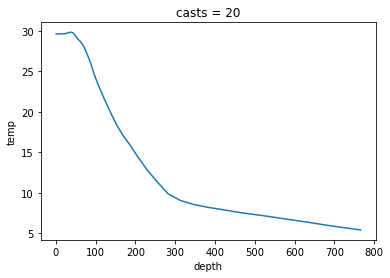

In [23]:
WOD_temperature_synthetic['temp'][20,:].plot()

In [16]:
model_temperature_level

<xarray.DataArray 'temp' (time: 365, st_ocean: 75, yt_ocean: 579, xt_ocean: 1000)>
dask.array<add, shape=(365, 75, 579, 1000), dtype=float32, chunksize=(31, 75, 579, 1000), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... -180.2 -180.1 -180.0
  * yt_ocean  (yt_ocean) float64 -49.96 -49.9 -49.83 ... -0.25 -0.15 -0.05
  * st_ocean  (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time      (time) datetime64[ns] 2018-01-01T12:00:00 ... 2018-12-31T12:00:00
Attributes:
    long_name:      Conservative temperature
    units:          K
    valid_range:    [-10. 500.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    coordinates:    geolon_t geolat_t
    standard_name:  sea_water_conservative_temperature

In [53]:
model_temperature_level

<xarray.Dataset>
Dimensions:         (longitude: 1000, latitude: 579, st_edges_ocean: 76,
                     time: 365, nv: 2)
Coordinates:
  * longitude       (longitude) float64 -279.9 -279.8 -279.7 ... -180.1 -180.0
  * latitude        (latitude) float64 -49.96 -49.9 -49.83 ... -0.25 -0.15 -0.05
    st_ocean        float64 0.5413
  * st_edges_ocean  (st_edges_ocean) float64 0.0 1.083 ... 5.61e+03 5.809e+03
  * time            (time) datetime64[ns] 2018-01-01T12:00:00 ... 2018-12-31T...
  * nv              (nv) float64 1.0 2.0
Data variables:
    temp            (time, latitude, longitude) float32 279.1 278.9 ... 302.9
    average_T1      (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2018-12-31
    average_T2      (time) datetime64[ns] 2018-01-02 2018-01-03 ... 2019-01-01
    average_DT      (time) timedelta64[ns] 1 days 1 days ... 1 days 1 days
    time_bounds     (time, nv) timedelta64[ns] 43099 days ... 43464 days
Attributes:
    filename:   ocean-3d-temp-1-daily-mean-ym_1987_01.nc
    title:      ACCESS-OM2-01
    grid_type:  mosaic
    grid_tile:  1
    history:    20200704T1458Z: /g/data/ik11/inputs/access-om2/bin/mppnccombi...

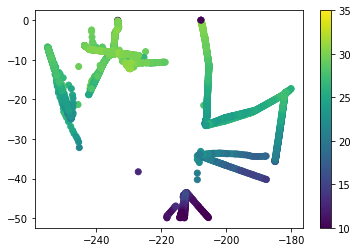

In [60]:
plt.scatter(WOD_temperature_synthetic['longitude'],WOD_temperature_synthetic['latitude'],c=WOD_temperature_synthetic['temp'][:,0],vmin=10,vmax=35)
plt.colorbar()

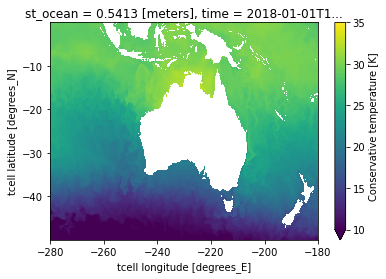

In [62]:
model_temperature_level[0,:,:].plot(vmin=10,vmax=35)

In [22]:
model_temperature_level

<xarray.Dataset>
Dimensions:         (longitude: 1000, latitude: 579, st_edges_ocean: 76,
                     time: 365, nv: 2)
Coordinates:
  * longitude       (longitude) float64 -279.9 -279.8 -279.7 ... -180.1 -180.0
  * latitude        (latitude) float64 -49.96 -49.9 -49.83 ... -0.25 -0.15 -0.05
    st_ocean        float64 0.5413
  * st_edges_ocean  (st_edges_ocean) float64 0.0 1.083 ... 5.61e+03 5.809e+03
  * time            (time) datetime64[ns] 2018-01-01T12:00:00 ... 2018-12-31T...
  * nv              (nv) float64 1.0 2.0
Data variables:
    temp            (time, latitude, longitude) float32 279.1 278.9 ... 302.9
    average_T1      (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2018-12-31
    average_T2      (time) datetime64[ns] 2018-01-02 2018-01-03 ... 2019-01-01
    average_DT      (time) timedelta64[ns] 1 days 1 days ... 1 days 1 days
    time_bounds     (time, nv) timedelta64[ns] 43099 days ... 43464 days
Attributes:
    filename:   ocean-3d-temp-1-daily-mean-ym_1987_01.nc
    title:      ACCESS-OM2-01
    grid_type:  mosaic
    grid_tile:  1
    history:    20200704T1458Z: /g/data/ik11/inputs/access-om2/bin/mppnccombi...

In [33]:
regridder.to_netcdf('/g/data4/ul08/CARS_v2/regrid_weights_xbt.nc')

'/g/data4/ul08/CARS_v2/regrid_weights_xbt.nc'

In [23]:
test_xbt.compute()

NameError: name 'test_xbt' is not defined

In [31]:
unique_days = np.unique(ds_WOD_stations['time.dayofyear'])

In [52]:
for i_day in unique_days:
    
    model_temperature_dayofyear = model_temperature.sel(time=model_temperature['time'].dt.dayofyear.isin([i_day]))
    WOD_time_index = ds_WOD_stations['time'].dt.dayofyear.isin([i_day])
    ds_WOD_stations_dayofyear = ds_WOD_stations.where(WOD_time_index,drop=True)
    

    dsa
    

2023-01-31 17:32:28,431 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.16 GiB -- Worker memory limit: 4.50 GiB
2023-01-31 17:32:28,529 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.17 GiB -- Worker memory limit: 4.50 GiB
2023-01-31 17:32:28,628 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- U

KeyboardInterrupt: 

Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/distributed/process.py", line 188, in _run
    target(*args, **kwargs)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/distributed/nanny.py", line 981, in _run
    asyncio.run(run())
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/asyncio/runners.py", line 44, in run
    return loop.run_until_complete(main)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/asyncio/base

In [46]:
WOD_time_index

<xarray.DataArray 'dayofyear' (casts: 3240)>
array([ True, False, False, ..., False, False, False])
Coordinates:
    lat      (casts) float32 -17.83 -16.73 -15.87 ... -14.03 -10.97 -17.31
    lon      (casts) float32 118.3 118.9 119.4 119.8 ... 108.6 107.9 106.7 118.5
Dimensions without coordinates: casts

In [51]:
ds_WOD_stations_dayofyear

<xarray.Dataset>
Dimensions:    (casts: 1)
Coordinates:
    lat        (casts) float32 -17.83
    lon        (casts) float32 118.3
Dimensions without coordinates: casts
Data variables:
    longitude  (casts) float32 -251.7
    latitude   (casts) float32 -17.83
    time       (casts) datetime64[ns] 2018-01-05T23:19:00.003204096

In [47]:
ds_WOD_stations

<xarray.Dataset>
Dimensions:    (casts: 3240)
Coordinates:
    lat        (casts) float32 -17.83 -16.73 -15.87 ... -14.03 -10.97 -17.31
    lon        (casts) float32 118.3 118.9 119.4 119.8 ... 107.9 106.7 118.5
Dimensions without coordinates: casts
Data variables:
    longitude  (casts) float32 -251.7 -251.1 -250.6 ... -262.0 -263.3 -251.5
    latitude   (casts) float32 -17.83 -16.73 -15.87 ... -14.03 -10.97 -17.31
    time       (casts) datetime64[ns] 2018-01-05T23:19:00.003204096 ... 2018-...

In [ ]:
regridder = xesmf.Regridder(model_temperature, ds_WOD_stations, 'bilinear', locstream_out=True)


In [38]:
regridder

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_579x1000_1x383.nc 
Reuse pre-computed weights? False 
Input grid shape:           (579, 1000) 
Output grid shape:          (1, 383) 
Periodic in longitude?      False

In [39]:
WOD_temperature_synthetic = regridder(model_temperature).compute()



2023-01-31 17:01:19,774 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.16 GiB -- Worker memory limit: 4.50 GiB
2023-01-31 17:01:19,871 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.17 GiB -- Worker memory limit: 4.50 GiB
2023-01-31 17:01:19,971 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- U

KeyboardInterrupt: 

2023-01-31 17:02:04,965 - distributed.nanny - WARNING - Worker process still alive after 3.1999989318847657 seconds, killing
2023-01-31 17:02:04,966 - distributed.nanny - WARNING - Worker process still alive after 3.1999992370605472 seconds, killing
2023-01-31 17:02:04,967 - distributed.nanny - WARNING - Worker process still alive after 3.1999992370605472 seconds, killing
2023-01-31 17:02:04,969 - distributed.nanny - WARNING - Worker process still alive after 3.1999992370605472 seconds, killing


In [24]:
WOD_temperature_synthetic

<xarray.Dataset>
Dimensions:   (time: 11688, st_ocean: 75, casts: 7930)
Coordinates:
  * st_ocean  (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time      (time) datetime64[ns] 1987-01-01T12:00:00 ... 2018-12-31T12:00:00
    lon       (casts) float32 101.5 101.5 102.0 101.4 ... 112.9 114.1 117.7
    lat       (casts) float32 -4.24 -4.236 -4.0 -4.32 ... -65.15 -65.05 -64.92
Dimensions without coordinates: casts
Data variables:
    temp      (time, st_ocean, casts) float32 dask.array<chunksize=(5, 75, 7930), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

In [109]:
model_temperature

<xarray.Dataset>
Dimensions:    (st_ocean: 75, time: 7930, y: 579, x: 1000)
Coordinates:
  * st_ocean   (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time       (time) datetime64[ns] 2018-01-01T12:00:00 ... 2018-12-31T12:00:00
    latitude   (y, x) float64 dask.array<chunksize=(579, 1000), meta=np.ndarray>
    longitude  (y, x) float64 dask.array<chunksize=(579, 1000), meta=np.ndarray>
Dimensions without coordinates: y, x
Data variables:
    temp       (time, st_ocean, y, x) float32 dask.array<chunksize=(8, 75, 579, 1000), meta=np.ndarray>

2023-01-31 15:43:51,289 - distributed.nanny - WARNING - Worker process still alive after 3.1999986267089846 seconds, killing


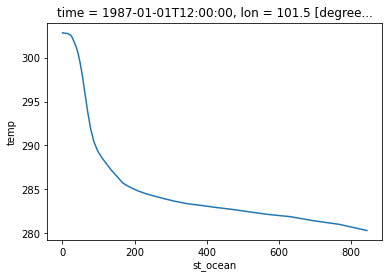

In [107]:
WOD_temperature_synthetic['temp'][0,:,0].plot()